In [1]:
import random
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from side_info_decoding.utils import set_seed, load_data_from_pids

seed = 666
set_seed(seed)

In [2]:
class GLM(torch.nn.Module):    
    def __init__(self, n_c, n_t, n_r):
        super(GLM, self).__init__()
        self.U = torch.nn.Parameter(torch.randn(n_c, n_r))
        self.V = torch.nn.Parameter(torch.randn(n_r, n_t))
        self.b = torch.nn.Parameter(torch.randn(1, n_c, 1))
        
    def forward(self, y):
        self.beta = torch.einsum("cr,rt->ct", self.U, self.V)
        x_pred = self.beta[None,:,:] * y + self.b
        return x_pred
    
def train_glm(
    X, 
    Y, 
    train,
    test,
    n_r = 2,
    learning_rate=1e-3,
    n_epochs=10000,
    ):
    
    _, n_c, n_t = X.shape
    glm = GLM(n_c, n_t, n_r)
    optimizer = torch.optim.Adam(glm.parameters(), lr=learning_rate)
    criterion = torch.nn.PoissonNLLLoss(full=True)
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)[:,None,:]
    train_x, test_x = X[train], X[test]
    train_y, test_y = Y[train], Y[test]
    
    losses = []
    for epoch in tqdm(range(n_epochs), desc="Train GLM:"):
        optimizer.zero_grad()
        x_pred = glm(train_y)
        loss = criterion(x_pred, train_x)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return glm, losses

In [3]:
pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
]

In [4]:
X_dict, Y_dict = load_data_from_pids(
    pids,
    brain_region="lp",
    behavior="wheel_speed",
    data_type="all_ks",
    n_t_bins = 50,
    t_before = .2,
    t_after = .8,
    normalize_input=False
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 367 (active: 367)
prior for this session is not found.
found 367 trials from 17.56 to 2310.24 sec.
found 131 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 367/367 [00:00<00:00, 1658.52it/s]


In [5]:
pid = pids[0]
X, Y = X_dict[pid], Y_dict[pid]
norm_Y = normalize(Y)
K, C, T = X.shape
print(X.shape)
print(Y.shape)

(367, 126, 50)
(367, 50)


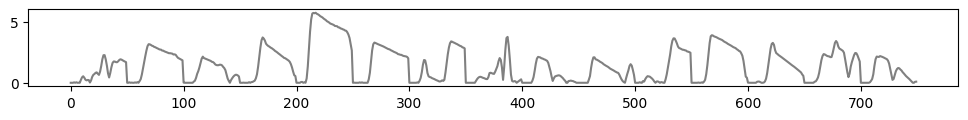

In [6]:
plt.figure(figsize=(12,1))
plt.plot(Y[10:10+15].flatten(), c="gray");

In [7]:
trial_idxs = np.arange(K)
random.shuffle(trial_idxs)
train, test = train_test_split(trial_idxs, test_size=0.1)

#### simple smoothing

In [20]:
smooth_X = np.array(
    [[gaussian_filter1d(X[k, c, :], 4) for c in range(C)] for k in range(K)]
)

train_X, test_X = smooth_X[train], smooth_X[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]
train_X = np.moveaxis(train_X, 1, -1).reshape((-1, C))
test_X = np.moveaxis(test_X, 1, -1).reshape((-1, C))
train_Y = train_Y.reshape((-1))
test_Y = test_Y.reshape((-1))
decoder = GridSearchCV(Ridge(), {"alpha": penalty})
decoder.fit(train_X, train_Y)
pred_Y = decoder.predict(test_X)
test_Y = test_Y.reshape(len(test), T)
pred_Y = pred_Y.reshape(len(test), T)
print(r2_score(test_Y.flatten(), pred_Y.flatten()))
print(pearsonr(test_Y.flatten(), pred_Y.flatten())[0])

0.19759382312528118
0.460366661923718


#### GLM

In [8]:
R = 10

glm, losses = train_glm(
    X = X, 
    Y = norm_Y, 
    train = train,
    test = test,
    n_r = R,
    learning_rate = 1e-3,
    n_epochs = 5000
)

Train GLM:: 100%|███████████████████████████| 5000/5000 [03:44<00:00, 22.32it/s]


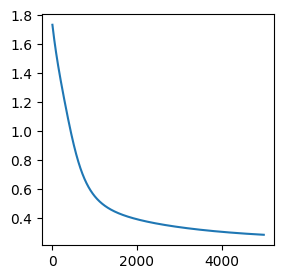

In [9]:
plt.figure(figsize=(3,3))
plt.plot(losses);

#### decode supervised latents from GLM

In [10]:
supervised_subspace = glm.U.detach().numpy()
subspace_weights = glm.V.detach().numpy()
smooth_subspace = np.array(
    [gaussian_filter1d(supervised_subspace[c, :], 4) for c in range(C)] 
)

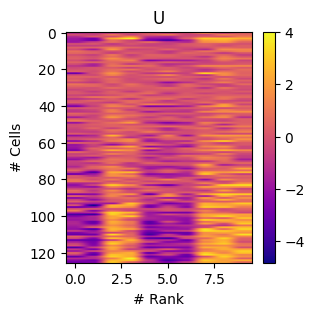

In [11]:
plt.figure(figsize=(3,3))
plt.imshow(supervised_subspace, aspect="auto", cmap="plasma")
plt.title("U")
plt.xlabel("# Rank")
plt.ylabel("# Cells")
plt.colorbar()
plt.show()

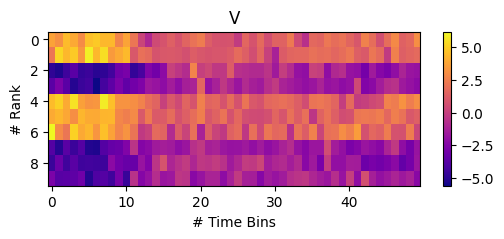

In [35]:
plt.figure(figsize=(6,2))
plt.imshow(subspace_weights, aspect="auto", cmap="plasma")
plt.title("V")
plt.xlabel("# Time Bins")
plt.ylabel("# Rank")
plt.colorbar()
plt.show()

In [13]:
all_proj = X.transpose(0,-1,1) @ supervised_subspace
weighted_proj = all_proj * subspace_weights.T
smooth_proj = np.array(
    [[gaussian_filter1d(weighted_proj[k, :, r], 4) for r in range(R)] for k in range(K)]
).transpose(0,-1,1)
print(smooth_proj.shape)

(367, 50, 10)


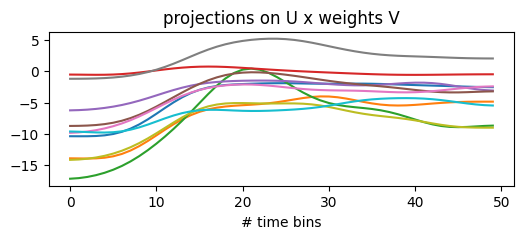

In [14]:
plt.figure(figsize=(6,2))
plt.plot(smooth_proj.mean(0))
plt.title("projections on U x weights V")
plt.xlabel("# time bins")
plt.show()

In [15]:
penalty = [0.001, 0.01, 1, 100, 1000, 10000]

train_X, test_X = smooth_proj[train], smooth_proj[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]
train_X = train_X.reshape((-1, R))
test_X = test_X.reshape((-1, R))
train_Y = train_Y.reshape((-1))
test_Y = test_Y.reshape((-1))
decoder = GridSearchCV(Ridge(), {"alpha": penalty})
decoder.fit(train_X, train_Y)
pred_Y = decoder.predict(test_X)
test_Y = test_Y.reshape(len(test), T)
pred_Y = pred_Y.reshape(len(test), T)
print(r2_score(test_Y.flatten(), pred_Y.flatten()))
print(pearsonr(test_Y.flatten(), pred_Y.flatten())[0])

0.34189780510507983
0.5858821091396077


#### decode reconstructed firing rates from GLM

In [31]:
penalty = [0.001, 0.01, 1, 100, 1000, 10000]

train_X, test_X = smooth_X[train], smooth_X[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]
train_X = train_X.transpose(0,-1,1).reshape((-1, C))
test_X = test_X.transpose(0,-1,1).reshape((-1, C))
train_Y = train_Y.reshape((-1))
test_Y = test_Y.reshape((-1))
decoder = GridSearchCV(Ridge(), {"alpha": penalty})
decoder.fit(train_X, train_Y)
pred_Y = decoder.predict(smooth_X.transpose(0,-1,1).reshape((-1, C))).reshape(len(X), T)

In [32]:
inferred_rates = glm(torch.tensor(pred_Y)[:,None,:]).exp().detach().numpy()
smooth_rates = np.array(
    [[gaussian_filter1d(inferred_rates[k, c, :], 4) for c in range(C)] for k in range(K)]
)

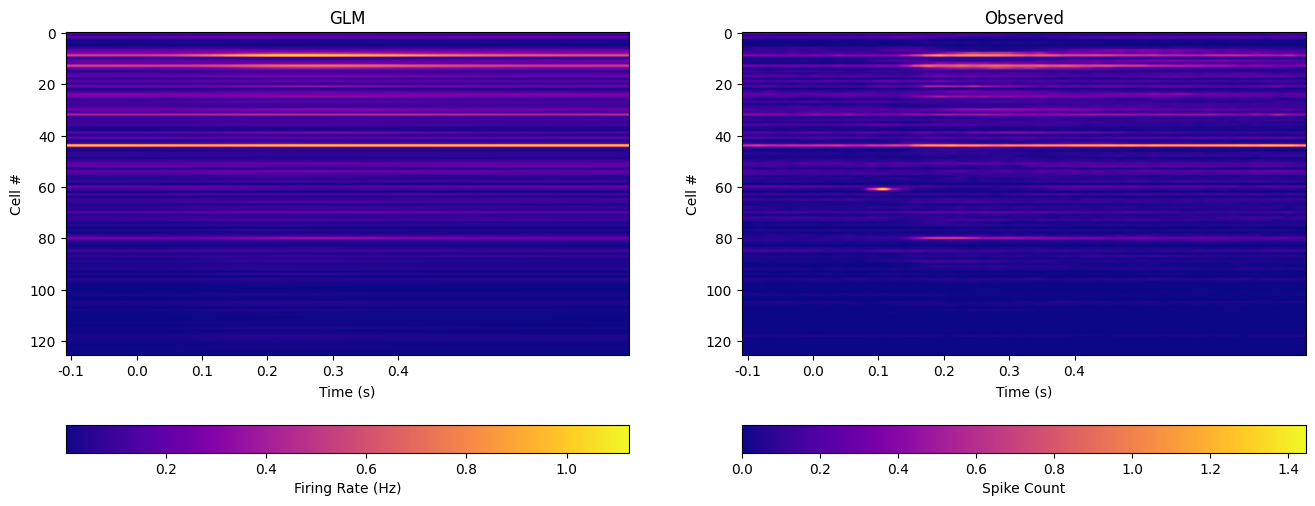

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
im1 = ax1.imshow(smooth_rates.mean(0), aspect="auto", cmap=plt.cm.plasma)
ax1.set_xticks(np.linspace(0, 29, 6), ['%.1f'%i for i in np.linspace(-.1, .4, 6)])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Cell #')
cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', label='Firing Rate (Hz)')
ax1.set_title('GLM')

im2 = ax2.imshow(X.mean(0), aspect="auto", cmap=plt.cm.plasma)
ax2.set_xticks(np.linspace(0, 29, 6), ['%.1f'%i for i in np.linspace(-.1, .4, 6)])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Cell #')
cbar = plt.colorbar(im2, ax=ax2, orientation='horizontal', label='Spike Count')
ax2.set_title('Observed');

In [34]:
penalty = [0.001, 0.01, 1, 100, 1000, 10000]

train_X, test_X = smooth_rates[train], smooth_rates[test]
train_Y, test_Y = norm_Y[train], norm_Y[test]
train_X = np.moveaxis(train_X, 1, -1).reshape((-1, C))
test_X = np.moveaxis(test_X, 1, -1).reshape((-1, C))
train_Y = train_Y.reshape((-1))
test_Y = test_Y.reshape((-1))
decoder = GridSearchCV(Ridge(), {"alpha": penalty})
decoder.fit(train_X, train_Y)
pred_Y = decoder.predict(test_X)
test_Y = test_Y.reshape(len(test), T)
pred_Y = pred_Y.reshape(len(test), T)
print(r2_score(test_Y.flatten(), pred_Y.flatten()))
print(pearsonr(test_Y.flatten(), pred_Y.flatten())[0])

0.4267273352526887
0.6542374791915052
